In [1]:
import deepSI_jax
from deepSI_jax import get_nu_ny_and_auto_norm
from deepSI_jax.utils import NRMS_error
import numpy as np

# Data generation
We utilize the same datas et as in example 3.

In [2]:
# Generate data
np.random.seed(0)
U = np.random.randn(10_000) # Input sequence
x = [0, 0] # Initial state
ylist = [] # Output sequence
K = np.array([0.75, -0.65])
for uk in U:
    ek = np.random.normal(loc=0, scale=0.05)
    ylist.append(x[0] + ek)  # Compute output
    x = x[0] / (1.2 + x[1]**2) + x[1] * 0.4 + K[0] * x[0] * ek, \
        x[1] / (1.2 + x[0]**2) + x[0] * 0.4 + uk + K[1] * x[1] * ek  # Advance state
Y = np.array(ylist)

U2 = np.random.randn(500) # Input sequence nr. 2
x = [0, 0] # Initial state nr. 2
ylist = [] # Output sequence nr. 2
for uk in U2:
    ek = np.random.normal(loc=0, scale=0.05)
    ylist.append(x[0] + ek)  # Compute output
    x = x[0] / (1.2 + x[1]**2) + x[1] * 0.4 + K[0] * x[0] * ek, \
        x[1] / (1.2 + x[0]**2) + x[0] * 0.4 + uk + K[1] * x[1] * ek  # Advance state
Y2 = np.array(ylist)

# Split dataset
U_train = U[:9000]
Y_train = Y[:9000]
U_test_1 = U[9000:]
Y_test_1 = Y[9000:]
U_test_2 = U2
Y_test_2 = Y2
U_test = [U_test_1, U_test_2]
Y_test = [Y_test_1, Y_test_2]

# Separated noise and process models
deepSI-jax offers the possibility of identifying seperated process and noise models to describe the dynamics of the data-generating system. This method has been recently proposed by Bemporad & Tóth, we now provide a quick introduction, but for more details, please refer to https://arxiv.org/pdf/2504.11982.

The main idea is to parametrize the process model as previously (ANN-SS formulation), and the inverse noise model can be expressed as
$$\hat{z}_{k+1} = \tilde{f}_\theta(\hat{z}_k, \hat{x}_k, u_k, \hat{e}_k),$$
$$\hat{e}_k = v_k - \tilde{h}_\theta(\hat{z}_k, \hat{x}_k, u_k),$$
where $\hat{z}_k$ is the state of the inverse noise model, and similarly as for the innovation noise filter, $\hat{e}_k$ denotes the discripancy between the measured output and the output of the process part. Moreover, $\tilde{f}$ and $\tilde{h}$ are also implemented as feedforward neural networks, with $\theta$ now combining their parameters alongside with the parameters of $f$, $h$, and the encoder. Since $v_k$ is described by an i.i.d. white noise process, its values naturally are not available, but take the expectation of $\mathbb{E}\{v_k\}=0$, to express the 1-step-ahead predictor based on the separated nose and process model, as
$$\hat{y}_k = h_\theta(\hat{x}_k, u_k) - \tilde{h}_\theta(\hat{z}_k, \hat{x}_k, u_k),$$
$$\hat{e}_k = y_k - h_\theta(\hat{x}_k, u_k),$$
$$\hat{x}_{k+1} = f_\theta(\hat{x}_k, u_k),$$
$$\hat{z}_{k+1} = \tilde{f}(\hat{z}_k, \hat{x}_k, u_k, \hat{e}_k).$$


As the above-described model can be only used for one-step-ahead prediction (since it uses the measured values of the output), for simulation, the approximation of $\hat{e}_k\approx -\tilde{h}_\theta(\hat{z}_k, \hat{x}_k, u_k)$ can be taken. The first step for co-estimating the combined model, is to initialize the structure as shown below. Naturally, the encoder network now estimates the initial state of both for the process and noise models.


In [3]:
nu, ny, norm = get_nu_ny_and_auto_norm(Y_train, U_train)
nx = 3
nz = 2
n_lag = 20

fx_dict = dict(nodes_per_layer=32)
hx_dict = dict(feedthrough=False)
fz_dict = dict(hidden_layers=1, nodes_per_layer=32)
hz_dict = dict(hidden_layers=2, nodes_per_layer=8, feedthrough=False)
encoder_dict = dict(nodes_per_layer=16)

model = deepSI_jax.SUBNET_separated_noise_model(nx=nx, nz=nz, ny=ny, nu=nu, norm=norm, fx_args=fx_dict, hx_args=hx_dict, fz_args=fz_dict, hz_args=hz_dict, use_encoder=True, encoder_lag=n_lag, encoder_args=encoder_dict, seed=2)

Then again, the same functions can be used for training the model.

In [4]:
# set loss function and optimization parameters
model.set_loss_fun(T=200, l2_reg=1e-4)   # no overlap (for simplicity)
model.optimization(adam_epochs=100, lbfgs_epochs=500, iprint=-1)  # can be trained longer for even better results

# Train model on data
model.fit(Y_train, U_train)

t0 = model.t_solve
print(f"Elapsed time: {t0} s")

L-BFGS-B done in 468 iterations.
Elapsed time: 22.409929037094116 s


And finally, model evaluations are done in a similar fashion as for the innovation noise structure,.

In [5]:
# First, estimate the initial state vector with the encoder net
Y_test_lag = [y[:n_lag] for y in Y_test]
U_test_lag = [u[:n_lag] for u in U_test]
xz0_test = model.encoder_estim_x0(Y_test_lag, U_test_lag)  # this now estimates the combine x and z states

In [6]:
# then we apply the model for one-step-ahead prediction
Y_test_act = [y[n_lag:] for y in Y_test]
U_test_act = [u[n_lag:] for u in U_test]
Yhat_test_pred, _ = model.predict_one_step_ahead(xz0_test, U_test_act, Y_test_act)
NRMSE_pred = NRMS_error(Y_test_act, Yhat_test_pred)
print(f"NRMSE (one-step-ahead-prediction): {NRMSE_pred:.4%}")

NRMSE (one-step-ahead-prediction): 8.3454%


In [7]:
# then, now for simulation
Yhat_test_sim, _ = model.simulate(xz0_test, U_test_act)  # notice how the simulate method does not need Y_test
NRMSE_sim = NRMS_error(Y_test_act, Yhat_test_sim)
print(f"NRMSE (simulation): {NRMSE_sim:.4%}")

NRMSE (simulation): 9.5398%


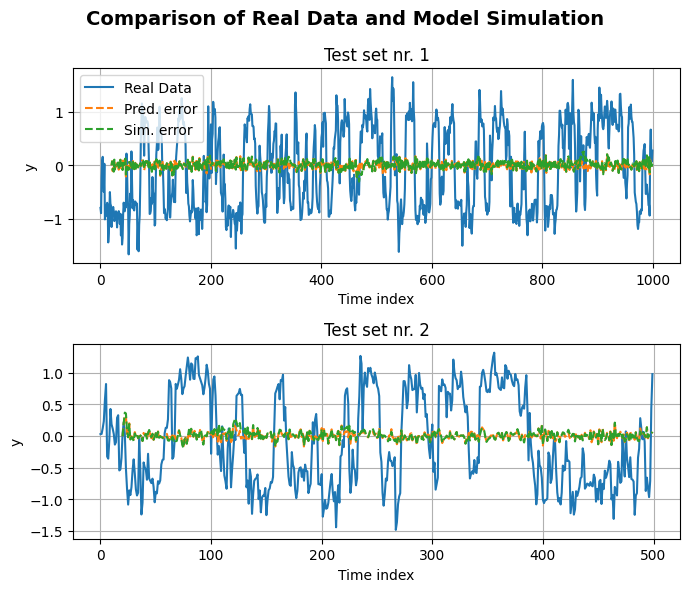

In [8]:
N_exp = len(U_test)
sim_idx = [np.arange(u.shape[0]) for u in U_test]

# Visualize simulation of the model
from matplotlib import pyplot as plt
fig, ax = plt.subplots(N_exp, 1, figsize=(7,6), layout="tight")
fig.suptitle('Comparison of Real Data and Model Simulation', fontsize=14, fontweight='bold')
for i in range(N_exp):
    ax[i].plot(sim_idx[i], Y_test[i], label='Real Data')
    ax[i].plot(sim_idx[i][n_lag:], Y_test_act[i] - Yhat_test_pred[i][:, 0], label='Pred. error', linestyle='--')
    ax[i].plot(sim_idx[i][n_lag:], Y_test[i][n_lag:] - Yhat_test_sim[i][:, 0], label='Sim. error', linestyle='--')
    ax[i].set_xlabel('Time index')
    ax[i].set_ylabel('y')
    ax[i].grid()
    ax[i].set_title(f"Test set nr. {i+1}")
ax[0].legend()
plt.show()

# Warm starting the optimization
A huge advantage of the separated parametrization is that the parameters describing the process model can be initialized by first training a deterministic model. To illustrate this, first we train a SUBNET model with the same hyperparameters, then use this model for warm start the optimization of the combined noise and process structure.

In [10]:
# deterministic model for warm-start
det_model = deepSI_jax.SUBNET(nx=nx, nu=nu, ny=ny, norm=norm, use_encoder=True, encoder_lag=n_lag, f_args=fx_dict, h_args=hx_dict)
det_model.set_loss_fun(l2_reg=1e-4, T=200)
det_model.optimization(adam_epochs=10, lbfgs_epochs=50, iprint=-1)
det_model.fit(Y_train, U_train)

L-BFGS-B done in 35 iterations.


Then simply provide the parameters of the trained deterministic model when initializing the combined model:

In [11]:
model = deepSI_jax.SUBNET_separated_noise_model(nx=nx, nz=nz, ny=ny, nu=nu, norm=norm, fx_args=fx_dict, hx_args=hx_dict, fz_args=fz_dict, hz_args=hz_dict, use_encoder=True, encoder_lag=n_lag, encoder_args=encoder_dict, seed=2, warm_start_params=det_model.params)

In [12]:
# set loss function and optimization parameters
model.set_loss_fun(T=200, l2_reg=1e-4)   # no overlap (for simplicity)
model.optimization(adam_epochs=100, lbfgs_epochs=500, iprint=-1)  # can be trained longer for even better results

# Train model on data
model.fit(Y_train, U_train)

t0 = model.t_solve
print(f"Elapsed time: {t0} s")

L-BFGS-B done in 460 iterations.
Elapsed time: 21.13218855857849 s


In [13]:
# First, estimate the initial state vector with the encoder net
Y_test_lag = [y[:n_lag] for y in Y_test]
U_test_lag = [u[:n_lag] for u in U_test]
xz0_test = model.encoder_estim_x0(Y_test_lag, U_test_lag)  # this now estimates the combine x and z states

# then we apply the model for one-step-ahead prediction
Y_test_act = [y[n_lag:] for y in Y_test]
U_test_act = [u[n_lag:] for u in U_test]
Yhat_test_pred, _ = model.predict_one_step_ahead(xz0_test, U_test_act, Y_test_act)
NRMSE_pred = NRMS_error(Y_test_act, Yhat_test_pred)
print(f"NRMSE (one-step-ahead-prediction): {NRMSE_pred:.4%}")

# then, now for simulation
Yhat_test_sim, _ = model.simulate(xz0_test, U_test_act)  # notice how the simulate method does not need Y_test
NRMSE_sim = NRMS_error(Y_test_act, Yhat_test_sim)
print(f"NRMSE (simulation): {NRMSE_sim:.4%}")

NRMSE (one-step-ahead-prediction): 8.3658%
NRMSE (simulation): 9.8570%


# Only tuning the parameters of the noise model
If a highly accurate deterministic model is available at hand that is cable to describe the process part of the system, then it is also possible the "freeze" its parameters and only tune the parameters of the noise structure. To demonstrate this, first, we train a deterministic model with now a little longer iteration count to provide a good estimate.

In [14]:
# deterministic model for warm-start
det_model = deepSI_jax.SUBNET(nx=nx, nu=nu, ny=ny, norm=norm, use_encoder=True, encoder_lag=n_lag, f_args=fx_dict, h_args=hx_dict)
det_model.set_loss_fun(l2_reg=1e-4, T=200)
det_model.optimization(adam_epochs=100, lbfgs_epochs=500, iprint=-1)
det_model.fit(Y_train, U_train)

L-BFGS-B done in 467 iterations.


Then the initialization of the combined structure is the same as previously, just set the `freeze_plant_model` flag to `True` value.

In [15]:
model = deepSI_jax.SUBNET_separated_noise_model(nx=nx, nz=nz, ny=ny, nu=nu, norm=norm, fx_args=fx_dict, hx_args=hx_dict, fz_args=fz_dict, hz_args=hz_dict, use_encoder=True, encoder_lag=n_lag, encoder_args=encoder_dict, seed=2, warm_start_params=det_model.params, freeze_plant_model=True)

In [16]:
# set loss function and optimization parameters
model.set_loss_fun(T=200, l2_reg=1e-4)   # no overlap (for simplicity)
model.optimization(adam_epochs=100, lbfgs_epochs=500, iprint=-1)  # can be trained longer for even better results

# Train model on data
model.fit(Y_train, U_train)

t0 = model.t_solve
print(f"Elapsed time: {t0} s")

L-BFGS-B done in 457 iterations.
Elapsed time: 18.771668910980225 s


In [17]:
# First, estimate the initial state vector with the encoder net
Y_test_lag = [y[:n_lag] for y in Y_test]
U_test_lag = [u[:n_lag] for u in U_test]
xz0_test = model.encoder_estim_x0(Y_test_lag, U_test_lag)  # this now estimates the combine x and z states

# then we apply the model for one-step-ahead prediction
Y_test_act = [y[n_lag:] for y in Y_test]
U_test_act = [u[n_lag:] for u in U_test]
Yhat_test_pred, _ = model.predict_one_step_ahead(xz0_test, U_test_act, Y_test_act)
NRMSE_pred = NRMS_error(Y_test_act, Yhat_test_pred)
print(f"NRMSE (one-step-ahead-prediction): {NRMSE_pred:.4%}")

# then, now for simulation
Yhat_test_sim, _ = model.simulate(xz0_test, U_test_act)  # notice how the simulate method does not need Y_test
NRMSE_sim = NRMS_error(Y_test_act, Yhat_test_sim)
print(f"NRMSE (simulation): {NRMSE_sim:.4%}")

NRMSE (one-step-ahead-prediction): 8.5340%
NRMSE (simulation): 10.4385%
